***IMPORTATION***

In [1]:
import pandas as pd
pd.options.plotting.backend = "plotly"
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import scipy
from scipy.fftpack import fft, fftfreq, fftshift, ifft
from scipy import signal
from scipy.signal import butter, lfilter, filtfilt
from optcutfreq import optcutfreq
import math 
from IPython.display import display, Math, Latex
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy.signal import find_peaks
from detecta import detect_peaks
import math
from detecta import detect_onset
from tnorma import tnorma
from scipy.interpolate import CubicSpline
from scipy.signal import argrelextrema
import random
import cogvefunc
from cogvefunc import cogve
from scipy.integrate import cumtrapz
from scipy import integrate
from scipy.signal import detrend
from scipy.interpolate import interp1d, PchipInterpolator



***OPEN***

In [2]:
# ENTER SUBJECT NUMBER and condition

subject_number = 23
condition = 'HPT'

In [3]:
def read_Force_Data(path_x, path_y, path_z, name_x, name_y, name_z):
    '''
        input: 
            - path_x= string containing the path to the mediolateral ground reaction force data to read (x)
            - path_y= string containing the path to the anteroposterior ground reaction force data to read (y)
            - path_z= string containing the path to the vertical ground reaction force data to read (z)
            - name_x = string containing the name of the column containing the mediolateral ground reaction force data (x)
            - name_y = string containing the name of the column containing the anteroposterior ground reaction force data (y)
            - name_z = string containing the name of the column containing the vertical ground reaction force data (z)
        output: 
            - df_combined = dataframe containing the ground reaction force data
    '''
    original_df_x = pd.read_csv(path_x, header=None)# header= None as shape is not convenient
    original_df_y = pd.read_csv(path_y, header=None)# header= None as shape is not convenient
    original_df_z = pd.read_csv(path_z, header=None)# header= None as shape is not convenient
    

    new_df_x = pd.DataFrame(original_df_x.values.reshape(-1, 1), columns=[name_x])# reshape as shape is not convenient
    new_df_y = pd.DataFrame(original_df_y.values.reshape(-1, 1), columns=[name_y])# reshape as shape is not convenient
    new_df_z = pd.DataFrame(original_df_z.values.reshape(-1, 1), columns=[name_z])# reshape as shape is not convenient
    df_combined = pd.concat([new_df_x, new_df_y, new_df_z], axis=1)
    
    return df_combined

def read_COP_Data(path_ap, path_ml, name_ap, name_ml):
    '''
        input: 
            - path_ap= string containing the path to center of pressure (COP) data file in the anteroposterior direction to read (y)
            - path_ml= string containing the path to center of pressure (COP) data file in the mediolateral direction to read (x)
            - name_ap = string containing the name of the column containing the COP data in the anteroposterior direction (y)
            - name_ml = string containing the name of the column containing the COP data in the mediolateral direction (x)
        output: 
            - df_combined = dataframe containing the COP data
    '''
    original_df_ap = pd.read_csv(path_ap, header=None)# header= None as shape is not convenient
    original_df_ml = pd.read_csv(path_ml, header=None)# header= None as shape is not convenient

    new_df_ap = pd.DataFrame(original_df_ap.values.reshape(-1, 1), columns=[name_ap])# reshape as shape is not convenient
    new_df_ml = pd.DataFrame(original_df_ml.values.reshape(-1, 1), columns=[name_ml])# reshape as shape is not convenient
    df_combined = pd.concat([new_df_ap, new_df_ml], axis=1)

    return df_combined

#Action
belt_velocity = (4/3.6)# in m/s
info = pd.read_excel('/Users/cyrilleetude/Downloads/e_walk_data_analysis/Data_analysis/Subjects.xlsx')
FP = read_Force_Data(path_x= f'/Users/cyrilleetude/Downloads/e_walk_data_analysis/Data_analysis/HPT_Flat/S{subject_number}_Data/Fx.csv',
path_y = f'/Users/cyrilleetude/Downloads/e_walk_data_analysis/Data_analysis/HPT_Flat/S{subject_number}_Data/Fy.csv', path_z= f'/Users/cyrilleetude/Downloads/e_walk_data_analysis/Data_analysis/HPT_Flat/S{subject_number}_Data/Fz.csv', 
name_x= 'Fx(N)', name_y= 'Fy(N)', name_z= 'Fz(N)')
FP.drop(index=0, inplace=True)
COP = read_COP_Data(path_ap= f'/Users/cyrilleetude/Downloads/e_walk_data_analysis/Data_analysis/HPT_Flat/S{subject_number}_Data/Cy.csv', path_ml= f'/Users/cyrilleetude/Downloads/e_walk_data_analysis/Data_analysis/HPT_Flat/S{subject_number}_Data/Cx.csv', name_ap='AP', name_ml='ML')
COP.drop(index=0, inplace=True)

***Signal Processing***

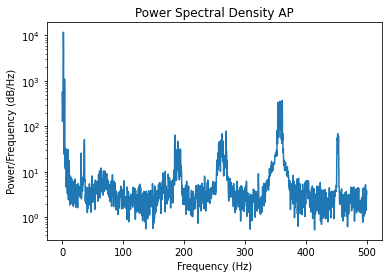

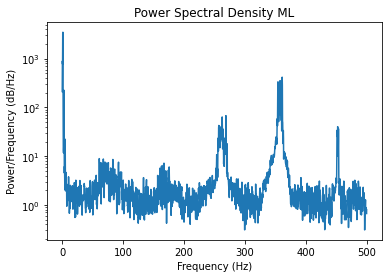

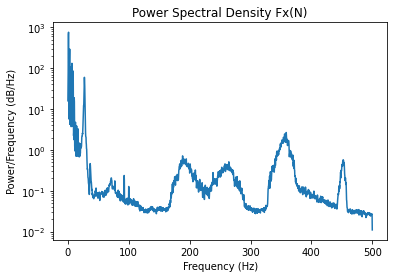

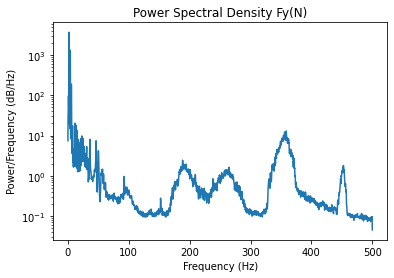

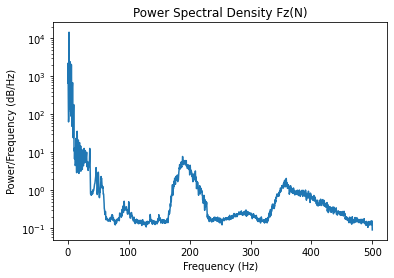

cutoff frequencies : AP = 100, ML = 100, FPx = 100, FPy = 100, FPz = 100


In [4]:
#Parameters
time_COP = np.linspace(0, len(COP), len(COP))/1000 #as we now that the measurement lasted around 5 min (~300 seconds)
time_FP = np.linspace(0, len(FP), len(FP))/1000
freq_COP = 1/np.round(np.mean(np.diff(time_COP)),4) #sampling rate
freq_FP = 1/np.round(np.mean(np.diff(time_FP)),4) #sampling rate
N_COP = COP.values.size
N_FP = FP.values.size

# Frequency Component
def get_fre_comp(Title, Data, sampling_rate, seg_len):
    '''
        input: 
            - Data= array containing the signal (time domain)
            - sampling_rate= float corresponding to the sampling frequency
            - seg_len = integer corresponding to the length of each overlapping segments
        output: 
            - plt.show() = plot representing the frequency component (psd)
    '''
    f, psd = signal.welch(Data, fs=sampling_rate, nperseg=seg_len)

    # Plot PSD
    plt.semilogy(f, psd)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power/Frequency (dB/Hz)')
    plt.title(f'Power Spectral Density {Title}')
    return plt.show()
Freq_Comp_COP_AP = get_fre_comp(Title = 'AP', Data = COP.AP.values, sampling_rate = freq_COP, seg_len = len(COP.AP.values)/100)
Freq_Comp_COP_ML = get_fre_comp(Title = 'ML', Data = COP.ML.values, sampling_rate = freq_COP, seg_len = len(COP.AP.values)/100)
Freq_Comp_FPx = get_fre_comp(Title = 'Fx(N)', Data = FP['Fx(N)'].values, sampling_rate = freq_FP, seg_len = len(COP.AP.values)/100)
Freq_Comp_FPy = get_fre_comp(Title = 'Fy(N)', Data = FP['Fy(N)'].values, sampling_rate = freq_FP, seg_len = len(COP.AP.values)/100)
Freq_Comp_FPz = get_fre_comp(Title = 'Fz(N)', Data = FP['Fz(N)'].values, sampling_rate = freq_FP, seg_len = len(COP.AP.values)/100)
# Residual Analysis to get Opt cut freq
# cutoff_AP = optcutfreq(COP.AP.values, freq_COP, show=False)
# cutoff_ML = optcutfreq(COP.ML.values, freq_COP, show=False)
# cutoff_FPx = optcutfreq(FP['Fx(N)'].values, freq_FP, show=False)
# cutoff_FPy = optcutfreq(FP['Fy(N)'].values, freq_FP, show=False)
# cutoff_FPz = optcutfreq(FP['Fz(N)'].values, freq_FP, show=False)

cutoff_AP = 100
cutoff_ML = 100
cutoff_FPx = 100
cutoff_FPy = 100
cutoff_FPz = 100
print(f'cutoff frequencies : AP = {cutoff_AP}, ML = {cutoff_ML}, FPx = {cutoff_FPx}, FPy = {cutoff_FPy}, FPz = {cutoff_FPz}')

# Apply the filter

def Filter(Data, cutoff_freq, sampling_rate, order):
    '''
        xth Order Butterworth low pass filter with 0 phase shift
        input: 
            - Data= array containing the signal (time domain)
            - sampling_rate= float corresponding to the sampling frequency
            - cutoff_freq = float corresponding to the cutoff frequency
            - order = integer representing the order of the filter
        output: 
            - filtered_data = array containing the filtered signal (time domain)
    '''
    npasses= 2 # 2 pass (bidirectional)
    C = (2**(1/npasses) - 1)**0.25 #correction
    b, a = butter(order, (cutoff_freq/C)/(sampling_rate/order)) #4th order with correction the cutoff frequency for the number of passes in the filter
    filtered_data = filtfilt(b, a, Data)  # filter with phase shift correction
    return filtered_data



COP_AP_processed = Filter(COP.AP.values, cutoff_AP, freq_COP, 4)
COP_ML_processed = Filter(COP.ML.values, cutoff_ML, freq_COP, 4)
FPx_processed = Filter(FP['Fx(N)'].values, cutoff_FPx, freq_FP, 4)
FPy_processed = Filter(FP['Fy(N)'].values, cutoff_FPy, freq_FP, 4)
FPz_processed = Filter(FP['Fz(N)'].values, cutoff_FPz, freq_FP, 4)


#Add columns 
COP['Time(s)'], COP['AP_Processed'], COP['ML_Processed'] = time_COP, COP_AP_processed, COP_ML_processed
# Check with the quality of the filter
# Quick_check = go.Figure()
# Quick_check.add_trace(go.Scatter(x=time_FP, y=FPz_processed,
#                     mode='lines',
#                     name='GRF',
#     line_color='black'))
    
# for template in ["plotly_white"]:
#     Quick_check.update_layout(template=template, title_text='Filter_check')
# Quick_check.update_layout(showlegend=True)
# Quick_check.update_yaxes(title_text="GRF")
# Quick_check.update_xaxes(title_text="Time")#, range=[0,5])
# Quick_check.show()

In [5]:
# FUNCTIONS
def COP_Butterfly_Event_Detection(time, cop_profile_AP, cop_profile_ML, window_size = 500, start_side = 'left', second_side = 'right'):  
    '''
        Function to detect heel strike and toe-off from cop butterfly profile as done by Roerdink et al. 2008 (with adjustable window). Default start side = left then right (lowercase letter)

        input:
            - time = numpy array containing the timestamp data in second (array([0. , 0.001 , 0.002, ...]))
            - cop_profile_AP : numpy array containing the processed COP anteroposterior displacement coordinates (AP)
            - cop_profile_ML : numpy array containing the processed COP mediolateral displacement coordinates (ML)
            - window_size : integer representing the size of the moving window (need to be ajusted depending on the condition as stated by Roerdink et al. 2008 who defined it at 30. Default = 500)
            - check : visualizations of the event detection quality (Default = False. 4 plots: 1 for toe off, one for heel strikes, 1 interactive for both based on the COP AP profile, 1 interactive for both based on the COP butterfly profile)
            
        output:
            - A list containing 3 lists with the indexes of the events
                0 - final_pattern[0] : list containing all the indexes (COP AP vs time) of every events
                1 - final_pattern[1] : list containing only the indexes (COP AP vs time) of the toe-off events
                2 - final_pattern[2] : list containing only the indexes (COP AP vs time) of the heel-strike events
                3 - final_pattern[3] : dataframe containing the ML coordinate and AP coordinate of each events separated (toe-off and heelstrike)
                4 - Plots if check is true

    '''
    

    def avoid_duplicate(cop_profile_AP):
        """
        Check if there is a duplicated value in cop_profile_AP (= numpy array). If yes, slightly modify the value (8th decimal) in order to avoid it. If no, do nothing.
        """
        lst = list(cop_profile_AP)
        seen = set()
        result = []
        if pd.Series(lst).duplicated().sum()>0: #if there is a duplicate
            for f in lst:
                key = round(f, 8)  # round to the x decimal place
                while key in seen:  # keep modifying the x decimal until there are no more duplicates
                    key = round(key + random.uniform(0, 0.00000000009), 16)  # add a random float between 0 and 0.00000000009 to the x decimal place
                seen.add(key)
                result.append(key)
        else: 
            result = lst
        modified_cop_profile_AP = result
        return np.array(modified_cop_profile_AP)

    def get_all_events(cop_profile_AP):
        """
        Get Heel strike (i.e., peaks of the COP AP profile against time) and Toe-off (i.e., valleys of the COP AP profile against time) events
        """
        heelstrikes_indexes = list(detect_peaks(avoid_duplicate(cop_profile_AP), show=False, mpd = window_size, mph = np.mean(avoid_duplicate(cop_profile_AP)), valley=True))
        toeoff_indexes = list(detect_peaks(avoid_duplicate(cop_profile_AP), show=False, mpd = window_size, mph = np.mean(avoid_duplicate(cop_profile_AP)), valley=False))
        gait_events_indexes = heelstrikes_indexes + toeoff_indexes
        gait_events_indexes.sort()
        return gait_events_indexes

    def get_toeoff_events(cop_profile_AP):
        """
        Get Toe-off (i.e., valleys of the COP AP profile against time) events
        """
        toeoff_indexes = list(detect_peaks(avoid_duplicate(cop_profile_AP), show=False, mpd = window_size, mph = np.mean(avoid_duplicate(cop_profile_AP)), valley=False))
        return toeoff_indexes

        
    def get_heelstrike_events(cop_profile_AP):
        """
        Get Heel strike (i.e., peaks of the COP AP profile against time) events
        """
        heelstrikes_indexes = list(detect_peaks(avoid_duplicate(cop_profile_AP), show=False, mpd = window_size, mph = np.mean(avoid_duplicate(cop_profile_AP)), valley=True))
        return heelstrikes_indexes

    def get_events_dataframe(time, cop_profile_AP, cop_profile_ML):
        """
        Get a dataframe containing the ML coordinate and AP coordinate of each events separated (toe-off and heelstrike)
        """
        df = pd.DataFrame({
            'Time (s)': time,
            'COP_AP': avoid_duplicate(cop_profile_AP),
            'COP_ML': cop_profile_ML
        })
        indexes_to_keep = get_all_events(cop_profile_AP)
        df = df.iloc[indexes_to_keep]
        label = np.where(np.isin(np.array(get_all_events(cop_profile_AP)), np.array(get_toeoff_events(cop_profile_AP))), 'toeoff_onset', 'heelstrike_onset')
        df['Event_Label'] = label
        return df

    def get_side(time, cop_profile_AP, cop_profile_ML, start_side, second_side):
        '''
            Add a  side column to the dataframe in order to differenciate right and left. 
        '''
        
        # Define the length of the array
        array_length_hs = len(get_events_dataframe(time, cop_profile_AP, cop_profile_ML).loc[get_events_dataframe(time, cop_profile_AP, cop_profile_ML)['Event_Label'] == 'heelstrike_onset'])
        array_length_to = len(get_events_dataframe(time, cop_profile_AP, cop_profile_ML).loc[get_events_dataframe(time, cop_profile_AP, cop_profile_ML)['Event_Label'] == 'toeoff_onset'])

        # Create an array of alternating left and right using numpy.tile
        hs_side = np.tile(np.array([start_side, second_side]), array_length_hs//2 + 1)[:array_length_hs]#default
        to_side = np.tile(np.array([second_side, start_side]), array_length_to//2 + 1)[:array_length_to]#default
        event_df_hs = get_events_dataframe(time, cop_profile_AP, cop_profile_ML).loc[get_events_dataframe(time, cop_profile_AP, cop_profile_ML)['Event_Label'] == 'heelstrike_onset']
        event_df_to = get_events_dataframe(time, cop_profile_AP, cop_profile_ML).loc[get_events_dataframe(time, cop_profile_AP, cop_profile_ML)['Event_Label'] == 'toeoff_onset']
        event_df_hs["Side"], event_df_to["Side"] =  hs_side, to_side
        event_df_side = pd.concat([event_df_hs, event_df_to], axis=0)
        event_df_side = event_df_side.sort_index()
        return event_df_side

    all_events = get_all_events(cop_profile_AP)
    to_events  = get_toeoff_events(cop_profile_AP)
    hs_events  = get_heelstrike_events(cop_profile_AP)
    event_df   = get_side(time, cop_profile_AP, cop_profile_ML, start_side, second_side)
    final_pattern = [all_events, to_events, hs_events, event_df]
    return final_pattern

def Check_Detection_Quality(df, length_check = 20):
    '''
    Function to check the detection performance from the COP_AP_Profile and COP_Butterfly profile
    input:
        - length_check: length of the visualization (need to be small to reduce the runtime if check is true). Default = 20
        - df : dataframe containing the ML coordinate and AP coordinate of each events separated (toe-off and heelstrike) + the side and the timestamp columns 
        
    '''
    df = df[:length_check]
    ### AP Profile
    COP_AP_Profile = go.Figure()
    COP_AP_Profile.add_trace(go.Scatter(x=df['Time (s)'], y=df.COP_AP.values,
                        mode='lines',
                        name='COP AP (mm)',
        line_color='black'))
    COP_AP_Profile.add_trace(go.Scatter(x=df.loc[(df['Event_Label'] == 'heelstrike_onset')&(df['Side'] == 'right')]['Time (s)'].values, y=df.loc[(df['Event_Label'] == 'heelstrike_onset')&(df['Side'] == 'right')].COP_AP.values,
                        mode='markers',
                        name='Heel Strike Right', marker=dict(symbol='square', color='red', size=15)))
    COP_AP_Profile.add_trace(go.Scatter(x=df.loc[(df['Event_Label'] == 'heelstrike_onset')&(df['Side'] == 'left')]['Time (s)'].values, y=df.loc[(df['Event_Label'] == 'heelstrike_onset')&(df['Side'] == 'left')].COP_AP.values,
                        mode='markers',
                        name='Heel Strike Left', marker=dict(symbol='square', color='green', size=15)))

    COP_AP_Profile.add_trace(go.Scatter(x=df.loc[(df['Event_Label'] == 'toeoff_onset')&(df['Side'] == 'right')]['Time (s)'].values, y=df.loc[(df['Event_Label'] == 'toeoff_onset')&(df['Side'] == 'right')].COP_AP.values,
                        mode='markers',
                        name='Toe-off Right', marker=dict(symbol='triangle-up', color='red', size=15)))
    COP_AP_Profile.add_trace(go.Scatter(x=df.loc[(df['Event_Label'] == 'toeoff_onset')&(df['Side'] == 'left')]['Time (s)'].values, y=df.loc[(df['Event_Label'] == 'toeoff_onset')&(df['Side'] == 'left')].COP_AP.values,
                        mode='markers',
                        name='Toe-off Left', marker=dict(symbol='triangle-up', color='green', size=15)))
    for template in ["plotly_white"]:
        COP_AP_Profile.update_layout(template=template, title_text='Event Detection Check (from COP AP Profile)')
    COP_AP_Profile.update_layout(showlegend=True)
    COP_AP_Profile.update_yaxes(title_text="COP AP (mm)")
    COP_AP_Profile.update_xaxes(title_text="Time (s)")
    ### Butterfly Profile
    COP_Butterfly_Profile = go.Figure()
    COP_Butterfly_Profile.add_trace(go.Scatter(x=df.COP_ML.values, y=df.COP_AP.values,
                        mode='lines',
                        name='COP Displacement (mm)',
        line_color= 'skyblue'))             
    COP_Butterfly_Profile.add_trace(go.Scatter(x=df.loc[(df['Event_Label'] == 'heelstrike_onset')&(df['Side'] == 'right')].COP_ML.values, y=df.loc[(df['Event_Label'] == 'heelstrike_onset')&(df['Side'] == 'right')].COP_AP.values,
                        mode='markers',
                        name='Heel Strike Right', marker=dict(symbol='square', color='red', size=15)))
    COP_Butterfly_Profile.add_trace(go.Scatter(x=df.loc[(df['Event_Label'] == 'heelstrike_onset')&(df['Side'] == 'left')].COP_ML.values, y=df.loc[(df['Event_Label'] == 'heelstrike_onset')&(df['Side'] == 'left')].COP_AP.values,
                        mode='markers',
                        name='Heel Strike Left', marker=dict(symbol='square', color='green', size=15)))
    
    COP_Butterfly_Profile.add_trace(go.Scatter(x=df.loc[(df['Event_Label'] == 'toeoff_onset')&(df['Side'] == 'right')].COP_ML.values, y=df.loc[(df['Event_Label'] == 'toeoff_onset')&(df['Side'] == 'right')].COP_AP.values,
                        mode='markers',
                        name='Toe-off Right', marker=dict(symbol='triangle-up', color='red', size=15)))
    COP_Butterfly_Profile.add_trace(go.Scatter(x=df.loc[(df['Event_Label'] == 'toeoff_onset')&(df['Side'] == 'left')].COP_ML.values, y=df.loc[(df['Event_Label'] == 'toeoff_onset')&(df['Side'] == 'left')].COP_AP.values,
                        mode='markers',
                        name='Toe-off Left', marker=dict(symbol='triangle-up', color='green', size=15)))
    for template in ["plotly_white"]:
        COP_Butterfly_Profile.update_layout(template=template, title_text='Event Detection Check (from COP Butterfly Profile)')
    COP_Butterfly_Profile.update_layout(showlegend=True)
    COP_Butterfly_Profile.update_yaxes(title_text="COP AP (mm)")
    COP_Butterfly_Profile.update_xaxes(title_text="COP ML (mm)")
    return COP_AP_Profile.show(), COP_Butterfly_Profile.show()
pattern = COP_Butterfly_Event_Detection(time = time_COP, cop_profile_AP = COP_AP_processed, cop_profile_ML = COP_ML_processed, window_size = 500, start_side = 'left', second_side = 'right')
events = pattern[-1]
Check_Detection_Quality(events, 2000)

(None, None)

In [6]:
events = events.loc[(events['Time (s)'] >0) & (events['Time (s)'] <300)  ]
Check_Detection_Quality(events, 2000)

(None, None)

In [7]:
events = events.loc[(events['Time (s)'] >100) & (events['Time (s)'] <182)  ]
Check_Detection_Quality(events, 2000)

(None, None)

In [8]:

#Fix again
left = np.where((events.Side == 'right')&(events.Event_Label == "toeoff_onset"))[0]
right = np.where((events.Side == 'left')&(events.Event_Label == "toeoff_onset"))[0]
# left = np.where((events.Side == 'right'))[0]#&(events.Event_Label == "heelstrike_onset"))[0]#toeoff_onset
# right = np.where((events.Side == 'left'))[0]#&(events.Event_Label == "heelstrike_onset"))[0]
for i in list(right):
    events.Side.values[i]= 'right'
for i in list(left):
    events.Side.values[i]= 'left'
events["Side"] = events.Side.values
Check_Detection_Quality(events, 2000)

(None, None)

In [9]:
# Spatotemporal Parameters calculation
# Data Preparation
parameters_df = events.loc[(events['Event_Label']=='heelstrike_onset')&(events['Time (s)']>=10)&(events['Time (s)']<=np.max(events['Time (s)'].values)-10)] #for the steps #remove start and end effects (first and last 10 seconds)
parameters_df_left = parameters_df.loc[(parameters_df['Side']=='left')] #for the left strides
parameters_df_right = parameters_df.loc[(parameters_df['Side']=='right')] #for the right strides

# Temporal parameters 
    # step/stride time 
step_time_array = np.diff(parameters_df['Time (s)'].values)
mean_step_time = np.mean(np.diff(parameters_df['Time (s)'].values))
std_step_time = np.std(np.diff(parameters_df['Time (s)'].values))
cov_step_time = (std_step_time/mean_step_time)*100

stride_time_left_array = np.diff(parameters_df_left['Time (s)'].values)
mean_stride_time_left = np.mean(np.diff(parameters_df_left['Time (s)'].values))
std_stride_time_left = np.std(np.diff(parameters_df_left['Time (s)'].values))
cov_stride_time_left = (std_stride_time_left/mean_stride_time_left)*100

stride_time_right_array = np.diff(parameters_df_right['Time (s)'].values)
mean_stride_time_right = np.mean(np.diff(parameters_df_right['Time (s)'].values))
std_stride_time_right = np.std(np.diff(parameters_df_right['Time (s)'].values))
cov_stride_time_right = (std_stride_time_right/mean_stride_time_right)*100

mean_stride_time = np.mean([mean_stride_time_left, mean_stride_time_right])
mean_cov_stride_time = np.mean([cov_stride_time_left, cov_stride_time_right])

    # Cadence 
complete_minutes_count = int(np.floor((np.max(parameters_df['Time (s)'].values) - np.min(parameters_df['Time (s)'].values))/60))
minutes_boundaries_array = []
for i in range(complete_minutes_count+1):
    minutes_boundaries_array.append(parameters_df['Time (s)'].values[0] + list(np.arange(0, complete_minutes_count*60 + 60, 60))[i])
minutes_boundaries_array = np.array(minutes_boundaries_array)
minutes_segmented_df = []
for i in range(len(minutes_boundaries_array)-1):
    minutes_segmented_df.append(parameters_df.loc[(parameters_df['Time (s)'] >= minutes_boundaries_array[i]) & (parameters_df['Time (s)'] <= minutes_boundaries_array[i+1])])
cadences_array = np.array([len(i) for i in minutes_segmented_df])
cadence = int(np.mean(cadences_array))

    # Stance/Swing
def clean_stance_phase_df(df):
    '''
        Function to make sure that the stance dataframe (input) start by heel strike and terminate by toe-off
    ''' 
    while df.iloc[0]['Event_Label'] != 'heelstrike_onset':
        df = df.iloc[1:]

    while df.iloc[-1]['Event_Label'] != 'toeoff_onset':
        df = df.iloc[:-1]

    return df

def clean_swing_phase_df(df):
    '''
        Function to make sure that the swing dataframe (input) start by toe-off and terminate by heel strike
    ''' 
    while df.iloc[0]['Event_Label'] != 'toeoff_onset':
        df = df.iloc[1:]

    while df.iloc[-1]['Event_Label'] != 'heelstrike_onset':
        df = df.iloc[:-1]

    return df

stance_left_df = clean_stance_phase_df(events.loc[(events['Side']=='left')&(events['Time (s)']>=10)&(events['Time (s)']<=np.max(events['Time (s)'].values)-10)])
stance_time_left_array = stance_left_df.loc[stance_left_df['Event_Label']=='toeoff_onset']['Time (s)'].values - stance_left_df.loc[stance_left_df['Event_Label']=='heelstrike_onset']['Time (s)'].values 
mean_stance_time_left = np.mean(stance_time_left_array)
std_stance_time_left = np.std(stance_time_left_array)
cov_stance_time_left = (std_stance_time_left/mean_stance_time_left)*100
mean_stance_time_left_perctg = (mean_stance_time_left * 100)/ mean_stride_time_left
swing_left_df = clean_swing_phase_df(events.loc[(events['Side']=='left')&(events['Time (s)']>=10)&(events['Time (s)']<=np.max(events['Time (s)'].values)-10)])
swing_time_left_array = swing_left_df.loc[swing_left_df['Event_Label']=='heelstrike_onset']['Time (s)'].values - swing_left_df.loc[swing_left_df['Event_Label']=='toeoff_onset']['Time (s)'].values 
mean_swing_time_left = np.mean(swing_time_left_array)
std_swing_time_left = np.std(swing_time_left_array)
cov_swing_time_left = (std_swing_time_left/mean_swing_time_left)*100
mean_swing_time_left_perctg = (mean_swing_time_left * 100)/ mean_stride_time_left

###

stance_right_df = clean_stance_phase_df(events.loc[(events['Side']=='right')&(events['Time (s)']>=10)&(events['Time (s)']<=np.max(events['Time (s)'].values)-10)])
stance_time_right_array = stance_right_df.loc[stance_right_df['Event_Label']=='toeoff_onset']['Time (s)'].values - stance_right_df.loc[stance_right_df['Event_Label']=='heelstrike_onset']['Time (s)'].values 
mean_stance_time_right = np.mean(stance_time_right_array)
std_stance_time_right = np.std(stance_time_right_array)
cov_stance_time_right = (std_stance_time_right/mean_stance_time_right)*100
mean_stance_time_right_perctg = (mean_stance_time_right * 100)/ mean_stride_time_right
swing_right_df = clean_swing_phase_df(events.loc[(events['Side']=='right')&(events['Time (s)']>=10)&(events['Time (s)']<=np.max(events['Time (s)'].values)-10)])
swing_time_right_array = swing_right_df.loc[swing_right_df['Event_Label']=='heelstrike_onset']['Time (s)'].values - swing_right_df.loc[swing_right_df['Event_Label']=='toeoff_onset']['Time (s)'].values 
mean_swing_time_right = np.mean(swing_time_right_array)
std_swing_time_right = np.std(swing_time_right_array)
cov_swing_time_right = (std_swing_time_right/mean_swing_time_right)*100
mean_swing_time_right_perctg = (mean_swing_time_right * 100)/ mean_stride_time_right


mean_stance_time = np.mean([mean_stance_time_left, mean_stance_time_right])
mean_cov_stance_time = np.mean([cov_stance_time_left, cov_stance_time_right])
mean_stance_time_perctg = np.mean([mean_stance_time_right_perctg, mean_stance_time_left_perctg])


mean_swing_time = np.mean([mean_swing_time_left, mean_swing_time_right])
mean_cov_swing_time = np.mean([cov_swing_time_left, cov_swing_time_right])
mean_swing_time_perctg = np.mean([mean_swing_time_right_perctg, mean_swing_time_left_perctg])



        # Double/Single Stance
def clean_events_df(df):
    '''
        Function to make sure that the events dataframe (input) start by heel strike and terminate by toe-off
    ''' 
    while df.iloc[0]['Event_Label'] != 'heelstrike_onset':
        df = df.iloc[1:]

    while df.iloc[-1]['Event_Label'] != 'toeoff_onset':
        df = df.iloc[:-1]

    return df

ds_ss_df = clean_events_df(events.loc[(events['Time (s)']>=10)&(events['Time (s)']<=np.max(events['Time (s)'].values)-10)])
ds_time_array = np.diff(ds_ss_df['Time (s)'].values)[0::2]
mean_ds_time = np.mean(ds_time_array)
std_ds_time = np.std(ds_time_array)
cov_ds_time = (std_ds_time/mean_ds_time)*100 
ds_time_perctg = (mean_ds_time * 100)/ mean_stride_time

##
ss_time_array = np.diff(ds_ss_df['Time (s)'].values)[1::2]
mean_ss_time = np.mean(ss_time_array)
std_ss_time = np.std(ss_time_array)
cov_ss_time = (std_ss_time/mean_ss_time)*100 
ss_time_perctg = (mean_ss_time * 100)/ mean_stride_time





# Spatial parameters 

    ## Width normalized
# gait_line_coordinate = (parameters_df_left['COP_ML'].values + parameters_df_right['COP_ML'].values)/2

mean_step_width = np.mean(np.abs(np.diff(parameters_df['COP_ML'].values)))/(info.loc[info['Subject #']==subject_number]['Height [m]'].values[0])
std_step_width = np.std(np.abs(np.diff(parameters_df['COP_ML'].values)))/(info.loc[info['Subject #']==subject_number]['Height [m]'].values[0])
cov_step_width = (std_step_width/mean_step_width)*100

# mean_stride_width_left = np.mean(np.abs(gait_line_coordinate - parameters_df_left['COP_ML'].values))/(info.loc[info['Subject #']==subject_number]['Height [m]'].values[0])
# std_stride_width_left = np.std(np.abs(gait_line_coordinate - parameters_df_left['COP_ML'].values))/(info.loc[info['Subject #']==subject_number]['Height [m]'].values[0])
# cov_stride_width_left = (std_stride_width_left/mean_stride_width_left)*100

# mean_stride_width_right = np.mean(np.abs(gait_line_coordinate - parameters_df_right['COP_ML'].values))/(info.loc[info['Subject #']==subject_number]['Height [m]'].values[0])
# std_stride_width_right = np.std(np.abs(gait_line_coordinate - parameters_df_right['COP_ML'].values))/(info.loc[info['Subject #']==subject_number]['Height [m]'].values[0])
# cov_stride_width_right = (std_stride_width_right/mean_stride_width_right)*100

    ## Length normalized

mean_step_length = ((mean_step_time*belt_velocity)*1000) /(info.loc[info['Subject #']==subject_number]['Height [m]'].values[0]) # in mm
std_step_length = ((std_step_time*belt_velocity)*1000) /(info.loc[info['Subject #']==subject_number]['Height [m]'].values[0]) # in mm
cov_step_length = (std_step_length/mean_step_length)*100 

mean_stride_length_left = ((mean_stride_time_left*belt_velocity)*1000) /(info.loc[info['Subject #']==subject_number]['Height [m]'].values[0]) # in mm
std_stride_length_left = ((std_stride_time_left*belt_velocity)*1000) /(info.loc[info['Subject #']==subject_number]['Height [m]'].values[0]) # in mm
cov_stride_length_left = (std_stride_length_left/mean_stride_length_left)*100

mean_stride_length_right = ((mean_stride_time_right*belt_velocity)*1000) /(info.loc[info['Subject #']==subject_number]['Height [m]'].values[0]) # in mm
std_stride_length_right = ((std_stride_time_right*belt_velocity)*1000) /(info.loc[info['Subject #']==subject_number]['Height [m]'].values[0]) # in mm
cov_stride_length_right = (std_stride_length_right/mean_stride_length_right)*100

mean_stride_length = np.mean([mean_stride_length_left, mean_stride_length_right])
mean_cov_stride_length = np.mean([cov_stride_length_left, cov_stride_length_right])

In [10]:
# COM outcomes normalized

    # Functions 
def get_Velocity(disp_array, sampling_rate):
    '''
        Calculate the velocity of COM
    '''
    x= np.gradient( disp_array, 1/sampling_rate)
    df = pd.DataFrame({ 'Vel_COM':x})
    return df.Vel_COM.values

def get_acceleration(disp_array, sampling_rate):
    '''
        Calculate the acceleration of COM
    '''
    x= np.gradient(np.gradient(disp_array, 1/sampling_rate), 1/sampling_rate)
    df = pd.DataFrame({ 'Acc_COM':x})
    return df.Acc_COM.values

def get_COMz (FPz, mass, start, stop, sampling_rate, g = 9.81):
    '''
        Function to get the vertical displacement, velocity and acceleration of the COM from FP
        
        input:
            - FPz = Vertical GRF (N)
            - mass = mass in kg
            - start = starting frame
            - stop = final frame
            - g = gravitational constant (default = 9.81)

        output:
            - list with 4 arrays:
                - [0] = displacement in m (0 leveled)
                - [1] = velocity in m/s (0 leveled)
                - [2] = acceleration in m/s^2 (0 leveled)
                - [3] = resultant vertical force 
    '''
    FPz = FPz[start:stop+1]
    ResFz = FPz - mass*g
    COM_acc_z = detrend(ResFz/ mass, type = 'linear')
    COM_vel_z = detrend(cumtrapz(COM_acc_z, dx=1/sampling_rate, initial=0), type = 'linear')
    dCOM_z = detrend(cumtrapz(COM_vel_z, dx=1/sampling_rate, initial=0), type = 'linear')
    output = [dCOM_z, COM_vel_z, COM_acc_z, ResFz]

    return output


    # Constant
time_COM = time_COP
freq_COM = freq_COP

    # VAriables (without last and first 10 seconds)

dCOM_y = (cogve(COP = COP_AP_processed/10, freq = int(freq_COP), mass = info.loc[info['Subject #']==subject_number]['Weight [kg]'].values[0], height = info.loc[info['Subject #']==subject_number]['Height [m]'].values[0]*100, show=False)[np.where(time_COM>=10)[0][0]:-np.where(time_COM>=10)[0][0]+1])*10 # displacement in mm
vCOM_y = get_Velocity(dCOM_y, freq_COM) #in mm/s
aCOM_y = get_acceleration(dCOM_y, freq_COM) #in mm/s2


dCOM_x = (cogve(COP = COP_ML_processed/10, freq = int(freq_COP), mass = info.loc[info['Subject #']==subject_number]['Weight [kg]'].values[0], height = info.loc[info['Subject #']==subject_number]['Height [m]'].values[0]*100, show=False)[np.where(time_COM>=10)[0][0]:-np.where(time_COM>=10)[0][0]+1])*10 # displacement in mm
vCOM_x = get_Velocity(dCOM_x, freq_COM) #in mm/s
aCOM_x = get_acceleration(dCOM_x, freq_COM) #in mm/s2


dCOM_z = (get_COMz(FPz = np.abs(FPz_processed), mass = info.loc[info['Subject #']==subject_number]['Weight [kg]'].values[0], start = 0, stop = len(FPz_processed), sampling_rate= freq_FP, g= 9.81 )[0][np.where(time_COM>=10)[0][0]:-np.where(time_COM>=10)[0][0]+1])*1000 #in mm
vCOM_z = (get_COMz(FPz = np.abs(FPz_processed), mass = info.loc[info['Subject #']==subject_number]['Weight [kg]'].values[0], start = 0, stop = len(FPz_processed), sampling_rate= freq_FP, g= 9.81 )[1][np.where(time_COM>=10)[0][0]:-np.where(time_COM>=10)[0][0]+1])*1000 #in mm/s
aCOM_z = (get_COMz(FPz = np.abs(FPz_processed), mass = info.loc[info['Subject #']==subject_number]['Weight [kg]'].values[0], start = 0, stop = len(FPz_processed), sampling_rate= freq_FP, g= 9.81 )[2][np.where(time_COM>=10)[0][0]:-np.where(time_COM>=10)[0][0]+1])*1000 #in mm/s2

fullCOM_df = pd.DataFrame({ 'Time (s)':time_COM[np.where(time_COM>=10)[0][0]:-np.where(time_COM>=10)[0][0]+1], 'dCOM_x':dCOM_x
, 'dCOM_y':dCOM_y, 'dCOM_z':dCOM_z, 'vCOM_x':vCOM_x, 'vCOM_y':vCOM_y, 'vCOM_z':vCOM_z, 'aCOM_x':aCOM_x, 'aCOM_y':aCOM_y, 'aCOM_z':aCOM_z})


fullCOM_df.index = np.array(list(fullCOM_df.index))+np.where(time_COM>=10)[0][0] #put correct indexes
fullCOM_df['id']= np.array(list(fullCOM_df.index))
    # Displacement/stability outcomes
        # Data preparation
cropped_events = events.loc[(events['Time (s)']>=10)&(events['Time (s)']<=np.max(events['Time (s)'].values)-10)][['Event_Label',    'Side']]
cropped_events['id']= np.array(list(cropped_events.index))


fullCOM_df= fullCOM_df.set_index('id').combine_first(cropped_events.set_index('id'))
fullCOM_df = fullCOM_df[['Time (s)', 'aCOM_x', 'aCOM_y', 'aCOM_z',
       'dCOM_x', 'dCOM_y', 'dCOM_z', 'vCOM_x', 'vCOM_y', 'vCOM_z', 'Event_Label', 'Side']]

left_hs_df = cropped_events.loc[(cropped_events['Event_Label'] == 'heelstrike_onset')&(cropped_events['Side'] == 'left')]
right_hs_df = cropped_events.loc[(cropped_events['Event_Label'] == 'heelstrike_onset')&(cropped_events['Side'] == 'right')]
stride_left_index = [] # list of arrays of containing the beginning [0] and end [1] of each GC left
for i in range(len(left_hs_df.id.to_list())-1):
    stride_left_index.append(np.array([left_hs_df.id.to_list()[i], left_hs_df.id.to_list()[i+1]]))
stride_right_index = []# list of arrays of containing the beginning [0] and end [1] of each GC right
for i in range(len(right_hs_df.id.to_list())-1):
    stride_right_index.append(np.array([right_hs_df.id.to_list()[i], right_hs_df.id.to_list()[i+1]]))

segmentedCOM_df_list_right = []# list of df of each GC right
for onset_array in stride_right_index:
    segmentedCOM_df_list_right.append(fullCOM_df.loc[(fullCOM_df.index >= onset_array[0])&(fullCOM_df.index <= onset_array[-1])])

segmentedCOM_df_list_left = []# list of df of each GC left
for onset_array in stride_left_index:
    segmentedCOM_df_list_left.append(fullCOM_df.loc[(fullCOM_df.index >= onset_array[0])&(fullCOM_df.index <= onset_array[-1])])

        # mean range during GC (frontal, vertical  and saggital)
            #Function
def rang(dCOM_array):
    '''
        Calculate range of COM displacement    
    '''
    rang = np.max(dCOM_array) - np.min(dCOM_array)  # range (maximum - minimum)
    return rang
            #Variable
range_x_left_array = np.array([rang(segmentedCOM_df_list_left[i].dCOM_x.values) for i in range(len(segmentedCOM_df_list_left))])
range_y_left_array = np.array([rang(segmentedCOM_df_list_left[i].dCOM_y.values) for i in range(len(segmentedCOM_df_list_left))])
range_z_left_array = np.array([rang(segmentedCOM_df_list_left[i].dCOM_z.values) for i in range(len(segmentedCOM_df_list_left))])

range_x_right_array = np.array([rang(segmentedCOM_df_list_right[i].dCOM_x.values) for i in range(len(segmentedCOM_df_list_right))])
range_y_right_array = np.array([rang(segmentedCOM_df_list_right[i].dCOM_y.values) for i in range(len(segmentedCOM_df_list_right))])
range_z_right_array = np.array([rang(segmentedCOM_df_list_right[i].dCOM_z.values) for i in range(len(segmentedCOM_df_list_right))])

            #Outcomes
mean_range_x_left = np.mean(range_x_left_array)
mean_range_y_left = np.mean(range_y_left_array)
mean_range_z_left = np.mean(range_z_left_array)

mean_range_x_right = np.mean(range_x_right_array)
mean_range_y_right = np.mean(range_y_right_array)
mean_range_z_right = np.mean(range_z_right_array)

std_range_x_left = np.std(range_x_left_array)
std_range_y_left = np.std(range_y_left_array)
std_range_z_left = np.std(range_z_left_array)

std_range_x_right = np.std(range_x_right_array)
std_range_y_right = np.std(range_y_right_array)
std_range_z_right = np.std(range_z_right_array)

cov_range_x_left = (std_range_x_left/mean_range_x_left)*100
cov_range_y_left = (std_range_y_left/mean_range_y_left)*100
cov_range_z_left = (std_range_z_left/mean_range_z_left)*100

cov_range_x_right = (std_range_x_right/mean_range_x_right)*100
cov_range_y_right = (std_range_y_right/mean_range_y_right)*100
cov_range_z_right = (std_range_z_right/mean_range_z_right)*100

mean_range_x = np.mean([mean_range_x_left, mean_range_x_right])
mean_range_y = np.mean([mean_range_y_left, mean_range_y_right])
mean_range_z = np.mean([mean_range_z_left, mean_range_z_right])

mean_cov_range_x = np.mean([cov_range_x_right, cov_range_x_left])
mean_cov_range_y = np.mean([cov_range_y_right, cov_range_y_left])
mean_cov_range_z = np.mean([cov_range_z_right, cov_range_z_left])

        # path length during GC (frontal, vertical  and saggital)
            #Function
def path_len(dCOM_array):
    '''
        Calculate range of COM displacement    
    '''
    tpath = np.sum(np.abs(np.diff(dCOM_array)))
    return tpath
            #Variable
path_len_x_left_array = np.array([path_len(segmentedCOM_df_list_left[i].dCOM_x.values) for i in range(len(segmentedCOM_df_list_left))])
path_len_y_left_array = np.array([path_len(segmentedCOM_df_list_left[i].dCOM_y.values) for i in range(len(segmentedCOM_df_list_left))])
path_len_z_left_array = np.array([path_len(segmentedCOM_df_list_left[i].dCOM_z.values) for i in range(len(segmentedCOM_df_list_left))])

path_len_x_right_array = np.array([path_len(segmentedCOM_df_list_right[i].dCOM_x.values) for i in range(len(segmentedCOM_df_list_right))])
path_len_y_right_array = np.array([path_len(segmentedCOM_df_list_right[i].dCOM_y.values) for i in range(len(segmentedCOM_df_list_right))])
path_len_z_right_array = np.array([path_len(segmentedCOM_df_list_right[i].dCOM_z.values) for i in range(len(segmentedCOM_df_list_right))])

            #Outcomes
mean_path_len_x_left = np.mean(path_len_x_left_array)
mean_path_len_y_left = np.mean(path_len_y_left_array)
mean_path_len_z_left = np.mean(path_len_z_left_array)

mean_path_len_x_right = np.mean(path_len_x_right_array)
mean_path_len_y_right = np.mean(path_len_y_right_array)
mean_path_len_z_right = np.mean(path_len_z_right_array)

std_path_len_x_left = np.std(path_len_x_left_array)
std_path_len_y_left = np.std(path_len_y_left_array)
std_path_len_z_left = np.std(path_len_z_left_array)

std_path_len_x_right = np.std(path_len_x_right_array)
std_path_len_y_right = np.std(path_len_y_right_array)
std_path_len_z_right = np.std(path_len_z_right_array)

cov_path_len_x_left = (std_path_len_x_left/mean_path_len_x_left)*100
cov_path_len_y_left = (std_path_len_y_left/mean_path_len_y_left)*100
cov_path_len_z_left = (std_path_len_z_left/mean_path_len_z_left)*100

cov_path_len_x_right = (std_path_len_x_right/mean_path_len_x_right)*100
cov_path_len_y_right = (std_path_len_y_right/mean_path_len_y_right)*100
cov_path_len_z_right = (std_path_len_z_right/mean_path_len_z_right)*100

mean_path_len_x = np.mean([mean_path_len_x_left, mean_path_len_x_right])
mean_path_len_y = np.mean([mean_path_len_y_left, mean_path_len_y_right])
mean_path_len_z = np.mean([mean_path_len_z_left, mean_path_len_z_right])

mean_cov_path_len_x = np.mean([cov_path_len_x_right, cov_path_len_x_left])
mean_cov_path_len_y = np.mean([cov_path_len_y_right, cov_path_len_y_left])
mean_cov_path_len_z = np.mean([cov_path_len_z_right, cov_path_len_z_left])

        # rms acc (frontal  and saggital)
            #Function
def rms_acc(aCOM_array):
    '''
        Calculate RMS acceleration of COM
    '''
    rms = np.sqrt(np.mean(aCOM_array** 2))
    return rms
            #Variable
rms_acc_x_left_array = np.array([rms_acc(segmentedCOM_df_list_left[i].aCOM_x.values) for i in range(len(segmentedCOM_df_list_left))])
rms_acc_y_left_array = np.array([rms_acc(segmentedCOM_df_list_left[i].aCOM_y.values) for i in range(len(segmentedCOM_df_list_left))])
rms_acc_x_right_array = np.array([rms_acc(segmentedCOM_df_list_right[i].aCOM_x.values) for i in range(len(segmentedCOM_df_list_right))])
rms_acc_y_right_array = np.array([rms_acc(segmentedCOM_df_list_right[i].aCOM_y.values) for i in range(len(segmentedCOM_df_list_right))])
            #Outcomes
                #  rms acc overall (frontal  and saggital)
overall_rms_aCOM_x = rms_acc(aCOM_x)
overall_rms_aCOM_y = rms_acc(aCOM_y)

                #  rms acc GC (frontal  and saggital)
mean_rms_acc_x_left = np.mean(rms_acc_x_left_array)
mean_rms_acc_y_left = np.mean(rms_acc_y_left_array)

mean_rms_acc_x_right = np.mean(rms_acc_x_right_array)
mean_rms_acc_y_right = np.mean(rms_acc_y_right_array)

std_rms_acc_x_left = np.std(rms_acc_x_left_array)
std_rms_acc_y_left = np.std(rms_acc_y_left_array)

std_rms_acc_x_right = np.std(rms_acc_x_right_array)
std_rms_acc_y_right = np.std(rms_acc_y_right_array)

cov_rms_acc_x_left = (std_rms_acc_x_left/mean_rms_acc_x_left)*100
cov_rms_acc_y_left = (std_rms_acc_y_left/mean_rms_acc_y_left)*100

cov_rms_acc_x_right = (std_rms_acc_x_right/mean_rms_acc_x_right)*100
cov_rms_acc_y_right = (std_rms_acc_y_right/mean_rms_acc_y_right)*100

mean_rms_acc_x = np.mean([mean_rms_acc_x_left, mean_rms_acc_x_right])
mean_rms_acc_y = np.mean([mean_rms_acc_y_left, mean_rms_acc_y_right])

mean_cov_rms_acc_x = np.mean([cov_rms_acc_x_right, cov_rms_acc_x_left])
mean_cov_rms_acc_y = np.mean([cov_rms_acc_y_right, cov_rms_acc_y_left])


        # mean velocity (frontal  and saggital)
            #Function
def mean_vel(vCOM_array):
    '''
        Calculate mean velocity of COM    
    '''
    v = np.mean(vCOM_array)
    return v
            #Variable
mean_vel_x_left_array = np.array([mean_vel(segmentedCOM_df_list_left[i].vCOM_x.values) for i in range(len(segmentedCOM_df_list_left))])
mean_vel_y_left_array = np.array([mean_vel(segmentedCOM_df_list_left[i].vCOM_y.values) for i in range(len(segmentedCOM_df_list_left))])
mean_vel_x_right_array = np.array([mean_vel(segmentedCOM_df_list_right[i].vCOM_x.values) for i in range(len(segmentedCOM_df_list_right))])
mean_vel_y_right_array = np.array([mean_vel(segmentedCOM_df_list_right[i].vCOM_y.values) for i in range(len(segmentedCOM_df_list_right))])
            #Outcomes
                #   overall (frontal  and saggital)
overall_mean_vCOM_x = mean_vel(vCOM_x)
overall_mean_vCOM_y = mean_vel(vCOM_y)

                #   GC (frontal  and saggital)
mean_mean_vel_x_left = np.mean(mean_vel_x_left_array)
mean_mean_vel_y_left = np.mean(mean_vel_y_left_array)

mean_mean_vel_x_right = np.mean(mean_vel_x_right_array)
mean_mean_vel_y_right = np.mean(mean_vel_y_right_array)

std_mean_vel_x_left = np.std(mean_vel_x_left_array)
std_mean_vel_y_left = np.std(mean_vel_y_left_array)

std_mean_vel_x_right = np.std(mean_vel_x_right_array)
std_mean_vel_y_right = np.std(mean_vel_y_right_array)

cov_mean_vel_x_left = (std_mean_vel_x_left/mean_mean_vel_x_left)*100
cov_mean_vel_y_left = (std_mean_vel_y_left/mean_mean_vel_y_left)*100

cov_mean_vel_x_right = (std_mean_vel_x_right/mean_mean_vel_x_right)*100
cov_mean_vel_y_right = (std_mean_vel_y_right/mean_mean_vel_y_right)*100

mean_mean_vel_x = np.mean([mean_mean_vel_x_left, mean_mean_vel_x_right])
mean_mean_vel_y = np.mean([mean_mean_vel_y_left, mean_mean_vel_y_right])

mean_cov_mean_vel_x = np.mean([cov_mean_vel_x_right, cov_mean_vel_x_left])
mean_cov_mean_vel_y = np.mean([cov_mean_vel_y_right, cov_mean_vel_y_left])    
        # vertical redirection angle (left only)
            #Function
def get_vel_redir_angle(start, stop, FPz, mass, sampling_rate, time, show= False, wind0 = 25):
    '''
        Function to estimate the step-wise center of mass vertical velocity redirection angle in rad.

        Input:
            - start, stop = integers corresponding to the start and stop points of the step (from hs ipsi lateral to hs contro lateral)
            - FPz = array containing the vertical GRF data
            - mass = float corresponding to the mass (in kg) of the participant
            - wind0 = integer corresponding to the window (before and after the frame of the redirection onset) in which the polynomial fit must be done. default = 25
            - sampling_rate = float corresponding to the sampling_rate of the FP data
            - time = array containing time data
            - show = boolean to show the plot or not. Default = False
        Output:
            - vel_redir_angle = step-wise center of mass vertical velocity redirection angle in rad
    '''
    
    FPz = np.abs(FPz[start:start+100])
    ResFz = FPz - mass*9.81
    COM_acc_z = ResFz/ mass
    COM_vel_z = detrend(cumtrapz(COM_acc_z, dx=1/sampling_rate, initial=0), type = 'linear')
    disCOM_z = detrend(cumtrapz(COM_vel_z, dx=1/sampling_rate, initial=0), type = 'linear')
    a = detect_peaks(disCOM_z, show=False, mpd = 50, valley=True)
    y1 = disCOM_z[a[0]-wind0:a[0]+1]
    y2 = disCOM_z[a[0]:a[0]+wind0+1]
    x1 = time[start:stop+100][a[0]-wind0:a[0]+1]
    x2 = time[start:stop+100][a[0]:a[0]+wind0+1]



    #find line of best fit

    x1, y1, x2, y2 = x1[:min([len(x1), len(y1)])], y1[:min([len(x1), len(y1)])], x2[:min([len(x2), len(y2)])], y2[:min([len(x2), len(y2)])]
    z1, b1 = np.polyfit(x1, y1, 1)
    z2, b2 = np.polyfit(x2, y2, 1)

    line1 = z1*x1+b1 #y value of the line as x = x
    line2 = z2*x2+b2 #y value of the line as x = x

    # test value
    interpolate_x1 = x1[-1]+(wind0*2)/freq_COM
    interpolate_x2 = x2[-1]+wind0/freq_COM

    # Finding the interpolation
    y1_interp = PchipInterpolator(x1, line1, extrapolate=True)
    y2_interp = PchipInterpolator(x2, line2, extrapolate=True)


    # Get angle
    x_corr1 , y_corr1 = interpolate_x1, y1_interp(interpolate_x1)+0
    x_corr2 , y_corr2 = interpolate_x2, y2_interp(interpolate_x2)+0
    x_origin, y_origin = [time[start:stop+100][i] for i in list(a)][0], [disCOM_z[int(i)] for i in list(a)][0]
    angle_down = np.deg2rad(np.abs(np.arctan((y_corr1-y_origin)/(x_corr1-x_origin))*180/np.pi))
    angle_up = np.deg2rad(np.abs(np.arctan((y_corr2-y_origin)/(x_corr2-x_origin))*180/np.pi))
    vel_redir_angle = angle_down + angle_up



    if show == True:
        Quick_check = go.Figure()
        Quick_check.add_trace(go.Scatter(x=time[start:stop+100], y=disCOM_z,
                            mode='lines',
                            name='',
            line_color='black'))
        Quick_check.add_trace(go.Scatter(x=[time[start:stop+100][i] for i in list(a)], y=[disCOM_z[int(i)] for i in list(a)],
                            mode='markers',
                            name='origin', marker=dict(symbol='square', color='red', size=15)))

        Quick_check.add_trace(go.Scatter(x=[time[start:stop+100][i-wind0] for i in list(a)], y=[disCOM_z[int(i)-wind0] for i in list(a)],
                            mode='markers',
                            name='boundary initial', marker=dict(symbol='square', color='green', size=15)))
        Quick_check.add_trace(go.Scatter(x=[time[start:stop+100][i+wind0] for i in list(a)], y=[disCOM_z[int(i)+wind0] for i in list(a)],
                            mode='markers',
                            name='boundary final', marker=dict(symbol='square', color='blue', size=15)))



        Quick_check.add_trace(go.Scatter(x=[interpolate_x1], y=[y1_interp(interpolate_x1)+0],
                            mode='markers',
                            name='point A', marker=dict(symbol='square', color='orange', size=15)))

        Quick_check.add_trace(go.Scatter(x=np.append(x1, interpolate_x1), y=np.append(line1, y1_interp(interpolate_x1)+0),
                            mode='lines',
                            name='final interp line1',
            line_color='pink'))
        Quick_check.add_trace(go.Scatter(x=[interpolate_x2], y=[y2_interp(interpolate_x2)+0],
                            mode='markers',
                            name='point B', marker=dict(symbol='square', color='orange', size=15)))

        Quick_check.add_trace(go.Scatter(x=np.append(x2, interpolate_x2), y=np.append(line2, y2_interp(interpolate_x2)+0),
                            mode='lines',
                            name='final interp line2',
            line_color='pink'))
        for template in ["plotly_white"]:
            Quick_check.update_layout(template=template, title_text='polyfit check')
        Quick_check.update_layout(showlegend=False)
        Quick_check.update_yaxes(title_text="dCOM_z")
        Quick_check.update_xaxes(title_text="Time")#, range=[0,5])
        Quick_check.show()
        return vel_redir_angle
    else:
        return vel_redir_angle
        #Prepare data
step_index_array = np.array([[list(parameters_df.index)[i],list(parameters_df.index)[i+1]] for i in range(len(list(parameters_df.index))-1)])
# drop = 350
min_value = 1
max_value = 500
step = 1

for drop in range(min_value, max_value + 1, step):
    try:
        # Run your code here with the current value
        # If the code runs successfully, break out of the loop
        # Otherwise, an error will be raised, and the loop will continue to the next value
        # Example:
        step_index_array = step_index_array[:-drop]
        vel_angle_array = np.array([get_vel_redir_angle(start=step_index[0], stop= step_index[-1], FPz= FPz_processed, mass= info.loc[info['Subject #']==subject_number]['Weight [kg]'].values[0], sampling_rate= freq_COP, time= time_FP, show= False, wind0 = 25) for step_index in list(step_index_array)])
        # result = your_code(drop)
        break
    except Exception as e:
        print(f"Error occurred with value {drop}: {str(e)}")

print("Code ran successfully with value:", drop)

# step_index_array = step_index_array[:-drop]
# vel_angle_array = np.array([get_vel_redir_angle(start=step_index[0], stop= step_index[-1], FPz= FPz_processed, mass= info.loc[info['Subject #']==subject_number]['Weight [kg]'].values[0], sampling_rate= freq_COP, time= time_FP, show= False, wind0 = 25) for step_index in list(step_index_array)])
        #Outcomes
mean_vel_angle = np.mean(vel_angle_array)





    # Dynamics outcomes (left only, frontal saggital vertical)
            #Function
def lin_mom(vCOM_array, mass):
    '''
        Calculate linear momentum of COM (in kg.mm / s)    
    '''
    m = mass * np.abs(vCOM_array)
    return m
            #Variable
lin_mom_x_left_array = np.array([lin_mom(segmentedCOM_df_list_left[i].vCOM_x.values, info.loc[info['Subject #']==subject_number]['Weight [kg]'].values[0]) for i in range(len(segmentedCOM_df_list_left))])
lin_mom_y_left_array = np.array([lin_mom(segmentedCOM_df_list_left[i].vCOM_y.values, info.loc[info['Subject #']==subject_number]['Weight [kg]'].values[0]) for i in range(len(segmentedCOM_df_list_left))])
            #Outcomes
                # Linear Momentum

overall_mean_lin_mom_x = np.mean(lin_mom(vCOM_x, info.loc[info['Subject #']==subject_number]['Weight [kg]'].values[0]))
overall_mean_lin_mom_y = np.mean(lin_mom(vCOM_y, info.loc[info['Subject #']==subject_number]['Weight [kg]'].values[0]))

Error occurred with value 1: expected non-empty vector for x
Error occurred with value 2: expected non-empty vector for x
Error occurred with value 3: expected non-empty vector for x
Error occurred with value 4: expected non-empty vector for x
Error occurred with value 5: expected non-empty vector for x
Error occurred with value 6: expected non-empty vector for x
Error occurred with value 7: expected non-empty vector for x
Error occurred with value 8: expected non-empty vector for x
Error occurred with value 9: expected non-empty vector for x
Error occurred with value 10: expected non-empty vector for x
Error occurred with value 11: expected non-empty vector for x
Error occurred with value 12: expected non-empty vector for x
Error occurred with value 13: expected non-empty vector for x
Code ran successfully with value: 14


/var/folders/rm/fz861vwx62vcc5c49ww298480000gq/T/ipykernel_34666/2186090998.py:430: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

/var/folders/rm/fz861vwx62vcc5c49ww298480000gq/T/ipykernel_34666/2186090998.py:431: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [11]:
# energetics outcomes 

FP_splited = pd.read_excel(f'/Users/cyrilleetude/Downloads/e_walk_data_analysis/Decomposed_FP_Data/S{subject_number}_C4_003Filtre2020151212.xlsx', usecols=['Time (s)','FzR(N)', 'FxR(N)', 'FyR(N)',
'FzL(N)','FxL(N)','FyL(N)', 'CoPxL(m)', 'CoPxR(m)', 'CoPyL(m)', 'CoPyR(m)'])
time_FP_splited = FP_splited['Time (s)'].values
sampling_freq_FP_splited = 1000 #Hz
FzR = FP_splited['FzR(N)'].values[np.where(time_FP_splited>=5)[0][0]:-np.where(time_FP_splited>=5)[0][0]+1] # revove start and end effect
FzL = FP_splited['FzL(N)'].values[np.where(time_FP_splited>=5)[0][0]:-np.where(time_FP_splited>=5)[0][0]+1] #revove start and end effect
FxR = FP_splited['FxR(N)'].values[np.where(time_FP_splited>=5)[0][0]:-np.where(time_FP_splited>=5)[0][0]+1] # revove start and end effect
FxL = FP_splited['FxL(N)'].values[np.where(time_FP_splited>=5)[0][0]:-np.where(time_FP_splited>=5)[0][0]+1] # revove start and end effect
FyR = FP_splited['FyR(N)'].values[np.where(time_FP_splited>=5)[0][0]:-np.where(time_FP_splited>=5)[0][0]+1] # revove start and end effect
FyL = FP_splited['FyL(N)'].values[np.where(time_FP_splited>=5)[0][0]:-np.where(time_FP_splited>=5)[0][0]+1] # revove start and end effect
COP_ap_FP_splited = (FP_splited['CoPyL(m)'].values + FP_splited['CoPyR(m)'].values)/2 #overoall cop ap
COP_ml_FP_splited = (FP_splited['CoPxL(m)'].values + FP_splited['CoPxR(m)'].values)/2 #overoall cop ml
COM_ap_FP_splited = cogve(COP = COP_ap_FP_splited, freq = int(sampling_freq_FP_splited), mass = info.loc[info['Subject #']==subject_number]['Weight [kg]'].values[0], height = info.loc[info['Subject #']==subject_number]['Height [m]'].values[0]*100, show=False)[np.where(time_FP_splited>=5)[0][0]:-np.where(time_FP_splited>=5)[0][0]+1]
COM_ml_FP_splited = cogve(COP = COP_ml_FP_splited, freq = int(sampling_freq_FP_splited), mass = info.loc[info['Subject #']==subject_number]['Weight [kg]'].values[0], height = info.loc[info['Subject #']==subject_number]['Height [m]'].values[0]*100, show=False)[np.where(time_FP_splited>=5)[0][0]:-np.where(time_FP_splited>=5)[0][0]+1]
time_FP_splited = time_FP_splited[np.where(time_FP_splited>=5)[0][0]:-np.where(time_FP_splited>=5)[0][0]+1]
time_FP_splited = np.linspace(0, time_FP_splited[-1], len(time_FP_splited))

#Gait event detection
hs_seg_right_onset = detect_onset(x= np.abs(FzR), show=False, threshold=5, n_above=40)[:,0][1:]
hs_seg_left_onset = detect_onset(x= np.abs(FzL), show=False, threshold=5, n_above=40)[:,0][1:-1]

to_seg_right_onset = detect_onset(x= np.abs(FzR), show=False, threshold=5, n_above=40)[:,1][1:]
to_seg_left_onset = detect_onset(x= np.abs(FzL), show=False, threshold=5, n_above=40)[:,1][1:-1]

cycle_duration_right = np.diff(hs_seg_right_onset)
cycle_duration_left = np.diff(hs_seg_left_onset)

ho_right_onset = np.around(np.delete(hs_seg_right_onset, -1) + (cycle_duration_right*0.40))
ho_left_onset = np.around(np.delete(hs_seg_left_onset, -1) + (cycle_duration_left*0.40))#i.e., heel off

#Get Push_off ranges
push_off_right_ranges = []
push_off_left_ranges = []
for start_right , end_right, start_left , end_left in zip(list(ho_right_onset), list(to_seg_right_onset), list(ho_left_onset), list(to_seg_left_onset)):
    push_off_right_ranges.append([int(start_right), end_right])
    push_off_left_ranges.append([int(start_left), end_left])


#Functions

# pushoff_start = 1039  
# pushoff_end = 1313 
def get_work(com_disp_ap, fp_force_ap, pushoff_start, pushoff_end):
    '''
        Function to calculate the total positive mechanical work at push-off (necessary to redirect the COM)
        
        input:
            - com_disp_ap = 1D array containing the AP COM displacement coordinate during push-off (in m)
            - fp_force_ap = 1D array containing the vertical GRF values during push-off (in N)
            - pushoff_start, pushoff_end = start and end indexes of push-off event

        output : a list containing the work [0] and power [1]
    '''

    # Calculate the displacement, work and force during push-off

    com_disp_ap = com_disp_ap[pushoff_start:pushoff_end]
    fp_force_ap = fp_force_ap[pushoff_start:pushoff_end]
    work = np.trapz(fp_force_ap * np.abs(com_disp_ap)) # in J
    return work

def get_power(com_disp_ap, fp_force_ap, sampling_freq, pushoff_start, pushoff_end):
    '''
        Function to calculate the instantaneous power at push-off (necessary to redirect the COM)
        
        input:
            - com_disp_ap = 1D array containing the AP COM displacement coordinate during push-off (in m)
            - fp_force_ap = 1D array containing the vertical GRF values during push-off (in N)
            - sampling_freq, pushoff_start, pushoff_end = sampling frequency, start and end indexes of push-off event

        output : a float corresponding to the power
    '''

    # Calculate the displacement, power and force during push-off

    com_disp_ap = com_disp_ap[pushoff_start:pushoff_end]
    fp_force_ap = fp_force_ap[pushoff_start:pushoff_end]
    inst_power = np.mean([fp_force_ap,  np.abs(get_Velocity(com_disp_ap, sampling_freq))]) # in watts
    return inst_power
# Outcomes
    #Work
gc_work_right_array = []
for ranges in push_off_right_ranges:
    gc_work_right_array.append(get_work(COM_ap_FP_splited, FyR, ranges[0], ranges[1]))
mean_work_right = np.mean(np.array(gc_work_right_array))
std_work_right = np.std(np.array(gc_work_right_array))
cov_work_right = (std_work_right/mean_work_right)*100
gc_work_left_array = []
for ranges in push_off_left_ranges:
    gc_work_left_array.append(get_work(COM_ap_FP_splited, FyL, ranges[0], ranges[1]))
mean_work_left = np.mean(np.array(gc_work_left_array))
std_work_left = np.std(np.array(gc_work_left_array))
cov_work_left = (std_work_left/mean_work_left)*100

overall_mean_work = np.mean([mean_work_right, mean_work_left])
overall_cov_work = np.mean([cov_work_right, cov_work_left])
    #Power
gc_power_right_array = []
for ranges in push_off_right_ranges:
    gc_power_right_array.append(get_power(COM_ap_FP_splited, FyR, sampling_freq_FP_splited, ranges[0], ranges[1]))
mean_power_right = np.mean(np.array(gc_power_right_array))
std_power_right = np.std(np.array(gc_power_right_array))
cov_power_right = (std_power_right/mean_power_right)*100
gc_power_left_array = []
for ranges in push_off_left_ranges:
    gc_power_left_array.append(get_power(COM_ap_FP_splited, FyL, sampling_freq_FP_splited, ranges[0], ranges[1]))
mean_power_left = np.mean(np.array(gc_power_left_array))
std_power_left = np.std(np.array(gc_power_left_array))
cov_power_left = (std_power_left/mean_power_left)*100

overall_mean_power = np.mean([mean_power_right, mean_power_left])
overall_cov_power = np.mean([cov_power_right, cov_power_left])



**SAVE**

In [12]:
#NORMAL
Results_df = pd.DataFrame({
# temporal
f'{"mean_step_time (s)"+ condition}':np.array([mean_step_time]), f'{"mean_stride_time (s)"+ condition}':np.array([mean_stride_time]), f'{"cadence (step/min)"+ condition}':np.array([cadence])
, f'{"mean_swing_time (s)"+ condition}':np.array([mean_swing_time]), f'{"mean_stance_time (s)"+ condition}':np.array([mean_stance_time])
, f'{"mean_ds_time (s)"+ condition}':np.array([mean_ds_time]), f'{"mean_ss_time (s)"+ condition}':np.array([mean_ss_time])

, f'{"cov_step_time (%)"+ condition}':np.array([cov_step_time]), f'{"cov_stride_time (%)"+ condition}':np.array([mean_cov_stride_time])
, f'{"cov_swing_time (%)"+ condition}':np.array([mean_cov_swing_time]), f'{"cov_stance_time (%)"+ condition}':np.array([mean_cov_stance_time])

, f'{"swing_time_perctg (%)"+ condition}':np.array([mean_swing_time_perctg]), f'{"stance_time_perctg (%)"+ condition}':np.array([mean_stance_time_perctg])
, f'{"ds_time_perctg (%)"+ condition}':np.array([ds_time_perctg]), f'{"ss_time_perctg (%)"+ condition}':np.array([ss_time_perctg])
# spatial
, f'{"mean_step_width (mm)"+ condition}':np.array([mean_step_width]), f'{"mean_step_length (mm)"+ condition}':np.array([mean_step_length]), f'{"mean_stride_length (mm)"+ condition}':np.array([mean_stride_length])
, f'{"cov_step_width (%)"+ condition}':np.array([cov_step_width]), f'{"cov_step_length (%)"+ condition}':np.array([cov_step_length]), f'{"cov_stride_length (%)"+ condition}':np.array([mean_cov_stride_length])

# COM

, f'{"mean_GC_range_ML (mm)"+ condition}':np.array([mean_range_x]), f'{"mean_GC_range_AP (mm)"+ condition}':np.array([mean_range_y])
, f'{"cov_range_ML (%)"+ condition}':np.array([mean_cov_range_x]), f'{"cov_range_AP (%)"+ condition}':np.array([mean_cov_range_y])
, f'{"mean_vel_ML (mm/s)"+ condition}':np.array([np.mean(np.abs(vCOM_x))]), f'{"mean_vel_AP (mm/s)"+ condition}':np.array([np.mean(np.abs(vCOM_y))])
, f'{"mean_GC_rms_acc_ML (mm/s2)"+ condition}':np.array([mean_rms_acc_x]), f'{"mean_GC_rms_acc_AP (mm/s2)"+ condition}':np.array([mean_rms_acc_y])
, f'{"cov_rms_acc_ML (%)"+ condition}':np.array([mean_cov_rms_acc_x]), f'{"cov_rms_acc_AP (%)"+ condition}':np.array([mean_cov_rms_acc_y])
, f'{"linear_momentum_ML (kg.m/s)"+ condition}':np.array([overall_mean_lin_mom_x/1000]), f'{"linear_momentum_AP (kg.m/s)"+ condition}':np.array([overall_mean_lin_mom_y/1000])
, f'{"est_Vert_vel_redir (rad)"+ condition}':np.array([mean_vel_angle])

# Energetics

, f'{"est_mean_mech_work_pushoff (J/kg)"+ condition}':np.array([overall_mean_work/info.loc[info['Subject #']==subject_number]['Weight [kg]'].values[0]]), f'{"est_inst_power_pushoff (W)"+ condition}':np.array([overall_mean_power])
, f'{"est_cov_mech_work_pushoff (%)"+ condition}':np.array([overall_cov_work]), f'{"est_cov_inst_power_pushoff (%)"+ condition}':np.array([overall_cov_power]),

})

In [13]:
# #NONE
# Results_df = pd.DataFrame({
# # temporal
# f'{"mean_step_time (s)"+ condition}':np.array([mean_step_time]), f'{"mean_stride_time (s)"+ condition}':np.array([mean_stride_time]), f'{"cadence (step/min)"+ condition}':np.array([cadence])
# , f'{"mean_swing_time (s)"+ condition}':np.array([mean_swing_time]), f'{"mean_stance_time (s)"+ condition}':np.array([mean_stance_time])
# , f'{"mean_ds_time (s)"+ condition}':np.array([mean_ds_time]), f'{"mean_ss_time (s)"+ condition}':np.array([mean_ss_time])

# , f'{"cov_step_time (%)"+ condition}':np.array([cov_step_time]), f'{"cov_stride_time (%)"+ condition}':np.array([mean_cov_stride_time])
# , f'{"cov_swing_time (%)"+ condition}':np.array([mean_cov_swing_time]), f'{"cov_stance_time (%)"+ condition}':np.array([mean_cov_stance_time])

# , f'{"swing_time_perctg (%)"+ condition}':np.array([mean_swing_time_perctg]), f'{"stance_time_perctg (%)"+ condition}':np.array([mean_stance_time_perctg])
# , f'{"ds_time_perctg (%)"+ condition}':np.array([ds_time_perctg]), f'{"ss_time_perctg (%)"+ condition}':np.array([ss_time_perctg])
# # spatial
# , f'{"mean_step_width (mm)"+ condition}':np.array([mean_step_width]), f'{"mean_step_length (mm)"+ condition}':np.array([mean_step_length]), f'{"mean_stride_length (mm)"+ condition}':np.array([mean_stride_length])
# , f'{"cov_step_width (%)"+ condition}':np.array([cov_step_width]), f'{"cov_step_length (%)"+ condition}':np.array([cov_step_length]), f'{"cov_stride_length (%)"+ condition}':np.array([mean_cov_stride_length])

# # COM

# , f'{"mean_GC_range_ML (mm)"+ condition}':np.array([mean_range_x]), f'{"mean_GC_range_AP (mm)"+ condition}':np.array([mean_range_y])
# , f'{"cov_range_ML (%)"+ condition}':np.array([mean_cov_range_x]), f'{"cov_range_AP (%)"+ condition}':np.array([mean_cov_range_y])
# , f'{"mean_vel_ML (mm/s)"+ condition}':np.array([np.mean(np.abs(vCOM_x))]), f'{"mean_vel_AP (mm/s)"+ condition}':np.array([np.mean(np.abs(vCOM_y))])
# , f'{"mean_GC_rms_acc_ML (mm/s2)"+ condition}':np.array([mean_rms_acc_x]), f'{"mean_GC_rms_acc_AP (mm/s2)"+ condition}':np.array([mean_rms_acc_y])
# , f'{"cov_rms_acc_ML (%)"+ condition}':np.array([mean_cov_rms_acc_x]), f'{"cov_rms_acc_AP (%)"+ condition}':np.array([mean_cov_rms_acc_y])
# , f'{"linear_momentum_ML (kg.m/s)"+ condition}':np.array([overall_mean_lin_mom_x/1000]), f'{"linear_momentum_AP (kg.m/s)"+ condition}':np.array([overall_mean_lin_mom_y/1000])
# , f'{"est_Vert_vel_redir (rad)"+ condition}':np.array([mean_vel_angle])

# # Energetics

# , f'{"est_mean_mech_work_pushoff (J/kg)"+ condition}':np.array([None]), f'{"est_inst_power_pushoff (W)"+ condition}':np.array([None])
# , f'{"est_cov_mech_work_pushoff (%)"+ condition}':np.array([None]), f'{"est_cov_inst_power_pushoff (%)"+ condition}':np.array([None]),

# })

In [14]:
final_res = pd.read_csv('/Users/cyrilleetude/Downloads/e_walk_data_analysis/Data_analysis/Results3.csv')
final_res = final_res.drop(['Unnamed: 0'], axis = 1)

In [15]:
Results_df = pd.concat([final_res, Results_df], axis=0)
Results_df

,mean_step_time (s)HPT,mean_stride_time (s)HPT,cadence (step/min)HPT,mean_swing_time (s)HPT,mean_stance_time (s)HPT,mean_ds_time (s)HPT,mean_ss_time (s)HPT,cov_step_time (%)HPT,cov_stride_time (%)HPT,cov_swing_time (%)HPT,...,mean_GC_rms_acc_AP (mm/s2)HPT,cov_rms_acc_ML (%)HPT,cov_rms_acc_AP (%)HPT,linear_momentum_ML (kg.m/s)HPT,linear_momentum_AP (kg.m/s)HPT,est_Vert_vel_redir (rad)HPT,est_mean_mech_work_pushoff (J/kg)HPT,est_inst_power_pushoff (W)HPT,est_cov_mech_work_pushoff (%)HPT,est_cov_inst_power_pushoff (%)HPT
0,0.597286,1.194606,100,0.425977,0.768582,0.171319,0.425977,2.678182,1.751109,4.166577,...,810.917806,11.779984,3.422442,8.284231,5.156350,0.020881,29.458498,39.717794,16.417988,6.386859
1,0.598985,1.197948,100,0.429222,0.768747,0.169782,0.429274,2.840148,1.755073,4.522909,...,862.791005,16.524378,3.221197,5.143832,4.769713,0.028940,6.859201,37.335236,59.606208,8.083155
2,0.540910,1.081917,110,0.378355,0.703532,0.162585,0.378311,3.435227,1.965380,5.844930,...,666.666332,7.333513,4.093825,4.429444,3.338647,0.023469,39.792784,30.768711,10.198182,6.492975
3,0.601693,1.203410,99,0.431938,0.771434,0.169749,0.431912,3.001065,2.044742,4.597528,...,807.137567,8.965984,3.174752,3.499362,4.019445,0.016701,39.897486,33.381834,6.800720,5.540106
4,0.570421,1.140846,105,0.397557,0.743336,0.172915,0.397538,2.863223,1.621737,4.652348,...,800.385428,7.683078,3.177773,6.246928,4.049518,0.010848,29.031651,33.114271,8.015436,5.981436
5,0.608907,1.217924,98,0.440204,0.777707,0.168744,0.440198,3.149278,1.992762,4.455360,...,695.544335,13.038923,3.501743,3.413880,4.048741,0.010439,14.287985,32.169976,19.523388,6.701913
6,0.569325,1.138684,105,0.412910,0.725770,0.156419,0.412915,3.453341,1.571514,4.133275,...,739.113360,11.840463,3.258128,5.141854,4.259383,0.019295,40.716070,38.426702,5.466642,4.427642
7,0.605751,1.211458,99,0.440618,0.770968,0.165211,0.440615,3.989714,2.789776,7.318269,...,779.390489,9.799495,6.056648,7.517050,5.415581,0.016084,43.774372,43.030190,8.646872,5.420556
8,0.594623,1.189552,101,0.439160,0.750302,0.155449,0.439149,3.034665,1.862904,4.139821,...,739.866693,9.868952,3.791957,7.772511,4.871247,0.010963,30.597073,41.889395,10.848767,5.190492
9,0.599586,1.199239,100,0.410009,0.789106,0.189558,0.410006,3.043870,1.997448,4.526512,...,731.548232,7.787893,2.962594,6.030501,4.938433,0.014250,4.854220,39.663240,60.272458,4.061904


In [16]:
Results_df.to_csv('/Users/cyrilleetude/Downloads/e_walk_data_analysis/Data_analysis/Results3.csv')